### Training the model:

In [ ]:
# # if needed:
# install dependencies
# !pip install torch
# !pip install transformers[torch]

In [ ]:
# imports
import torch
import pandas as pd
import numpy as np
from torch.utils.data.dataloader import DataLoader
from google.colab import drive
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
import math
import time
import matplotlib.pyplot as plt

np.random.seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # if using GPU

In [ ]:
# mount drive
drive.mount('/content/drive')

# define path to folder - CHANGE TO WHICHEVER DIRECTORY YOU WANT
path_folder = f"/content/drive/MyDrive/Deep_Learning_project/splits"
path_out = f"/content/drive/MyDrive/Deep_Learning_project/model"

path_folder_tokenizer = f"/content/drive/MyDrive/Deep_Learning_project/splits/tokenizer"

Mounted at /content/drive


In [ ]:
input_ids_path = path_folder+'/all_input_ids.npy'
attn_masks_path = path_folder+'/all_attention_masks.npy'

In [ ]:
# load pre-trained CausalLM GPT-2 model and the matching tokenizer
tokenizer = AutoTokenizer.from_pretrained(path_folder_tokenizer)

configuration = AutoModelForCausalLM.from_pretrained('gpt2')

model = AutoModelForCausalLM.from_pretrained('gpt2', config=configuration)  # load pre-trained causal LM model

model.resize_token_embeddings(len(tokenizer))

# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # if using GPU
model = model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# data set class, implimenting __init__, __len__, __getitem__ for dataloader purposes
class songsDataset:
    def __init__(self, input_ids, attn_masks):
        self.input_ids = input_ids
        self.attn_masks = attn_masks

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return torch.tensor(self.input_ids[idx], device=device), torch.tensor(self.attn_masks[idx], device=device)

In [ ]:
# load input ids and attention masks
input_ids = np.load(input_ids_path)
attn_masks = np.load(attn_masks_path)

print(f"input_ids length : {len(input_ids)}")
print(f"attn_masks length : {len(attn_masks)}")

# split into training and validation by using the same random state
input_ids_train, input_ids_val = train_test_split(input_ids, test_size = 0.0005, random_state=123)
attn_masks_train, attn_masks_val = train_test_split(attn_masks, test_size = 0.0005, random_state=123)

# create instances of training and validation datasets
dataset_train = songsDataset(input_ids_train, attn_masks_train)
dataset_val = songsDataset(input_ids_val, attn_masks_val)

print("len of train dataset:", len(dataset_train))
print("len of val dataset:", len(dataset_val))

input_ids length : 276986
attn_masks length : 276986
len of train dataset: 276847
len of val dataset: 139


In [ ]:
# hyperparameters
batch_size = 10
learning_rate = 0.0001

# number of epoch
num_epochs = 1

In [ ]:
# define dataloaders
train_dataloader = DataLoader(dataset_train, batch_size = batch_size)
validation_dataloader = DataLoader(dataset_val, batch_size = batch_size)

In [ ]:
# validation loop function
def validate_model(validation_loader, m):
    total_val_loss = 0
    val_steps = len(validation_dataloader)

    # iterate over validation set
    for ids, masks in validation_dataloader:
        with torch.no_grad():  # disable gradients for validation
            outputs = m(ids, attention_mask = masks, labels = ids)  # run model forward

            loss = outputs[0]
            batch_loss = loss.item()
            total_val_loss += batch_loss
    return total_val_loss / val_steps  # return average loss

In [ ]:
# training loop function
def train_model(train_loader, validation_loader, m, num_e, lr):
    epochs = range(num_e)
    num_batches = len(train_loader)
    # initialize lists of batch-step train and 1000-step validation losses
    train_losses = []
    validation_losses = []

    # optimiser
    optimizer = torch.optim.Adam(m.parameters(), lr=lr)

    # training loop
    for epoch in epochs:
        print(f"------------------- Epoch {epoch+1} / {num_e} -------------------")
        # iterate over train set
        for i,(ids, masks) in enumerate(train_loader):
            if i % 1000 == 0:
                print(f"Batch {i+1} / {num_batches}")

            model.train()  # training mode

            m.zero_grad()

            outputs = m(ids, attention_mask = masks, labels = ids)  # run model forward

            loss = outputs[0]
            batch_loss = loss.item()
            train_losses.append(batch_loss)  # save batch-step training loss

            loss.backward()  # optimize
            optimizer.step()

            if i%1000 == 0:
                validation_losses.append(validate_model(validation_loader, m))  # save 1000-batch-step validation loss

    return train_losses, validation_losses  # return training losses and validation losses

In [ ]:
time0 = time.time()

# run full training
train_losses, validation_losses = train_model(train_dataloader, validation_dataloader, model, num_epochs, learning_rate)

print(f"Train time: {time.time() - time0}")

------------------- Epoch 1 / 1 -------------------
Batch 1 / 27685
Batch 1001 / 27685
Batch 2001 / 27685
Batch 3001 / 27685
Batch 4001 / 27685
Batch 5001 / 27685
Batch 6001 / 27685
Batch 7001 / 27685
Batch 8001 / 27685
Batch 9001 / 27685
Batch 10001 / 27685
Batch 11001 / 27685
Batch 12001 / 27685
Batch 13001 / 27685
Batch 14001 / 27685
Batch 15001 / 27685
Batch 16001 / 27685
Batch 17001 / 27685
Batch 18001 / 27685
Batch 19001 / 27685
Batch 20001 / 27685
Batch 21001 / 27685
Batch 22001 / 27685
Batch 23001 / 27685
Batch 24001 / 27685
Batch 25001 / 27685
Batch 26001 / 27685
Batch 27001 / 27685
Train time: 32829.256705999374


In [ ]:
# save model to file
model.save_pretrained(f'{path_out}')

In [ ]:
print(len(train_losses))
print(len(validation_losses))

27685
28


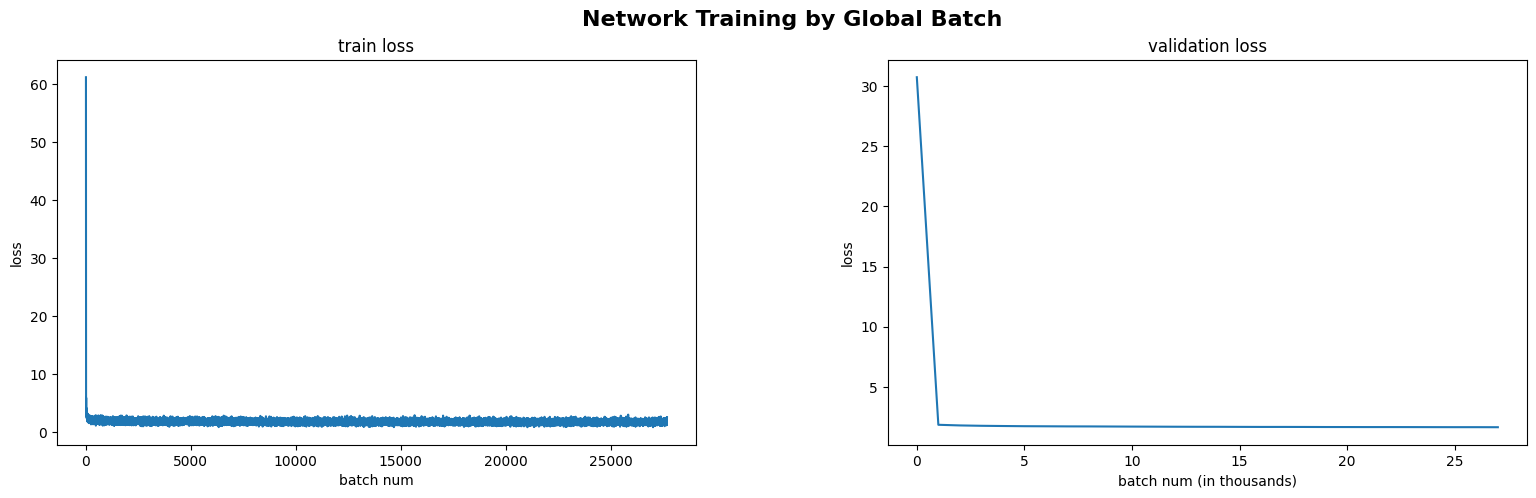

In [ ]:
# create plots
plt.figure(figsize=(15, 5))
X_trains = range(int(len(train_losses)))
X_valids = range(int(len(validation_losses)))

plt.subplot(1, 2, 1)
plt.plot(np.array(X_trains), np.array(train_losses))
plt.xlabel("batch num")
plt.ylabel("loss")
plt.title("train loss")

plt.subplot(1, 2, 2)
plt.plot(np.array(X_valids), np.array(validation_losses))
plt.xlabel("batch num (in thousands)")
plt.ylabel("loss")
plt.title("validation loss")

plt.suptitle(f"Network Training by Global Batch", fontsize=16, fontweight='bold')
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.3)
plt.show()

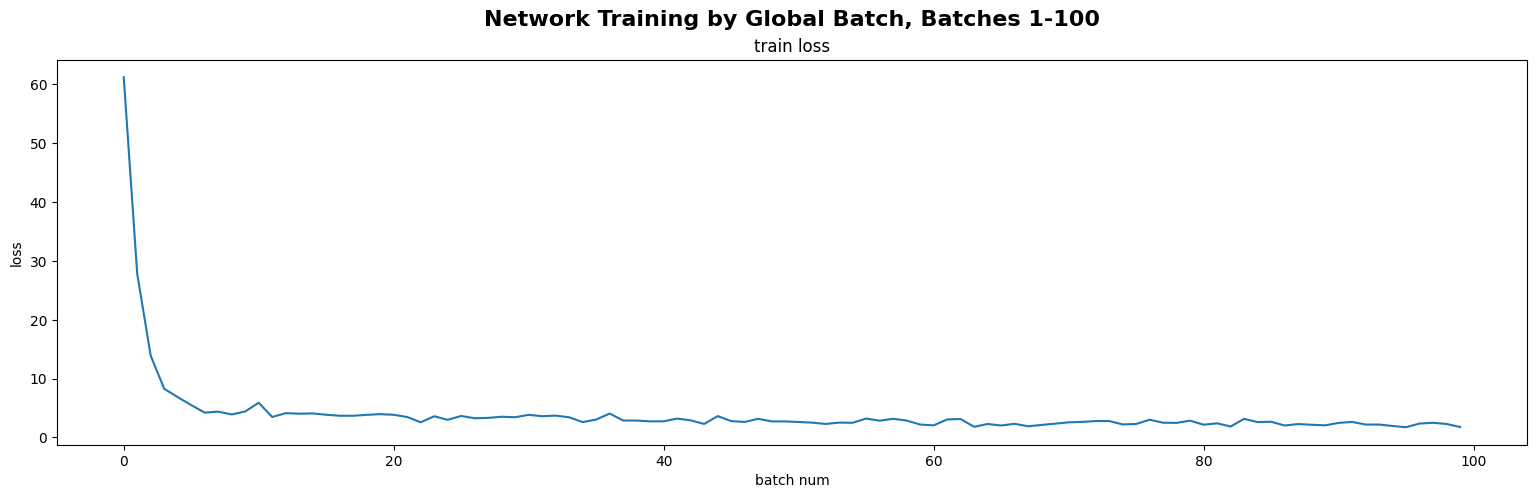

In [ ]:
# create plot -- first 100 batches, to show how the model learns in the first 100 batches
plt.figure(figsize=(15, 5))
X_trains = range(int(len(train_losses[0:100])))

plt.plot(np.array(X_trains), np.array(train_losses[0:100]))
plt.xlabel("batch num")
plt.ylabel("loss")
plt.title("train loss")

plt.suptitle(f"Network Training by Global Batch, Batches 1-100", fontsize=16, fontweight='bold')
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.3)
plt.show()

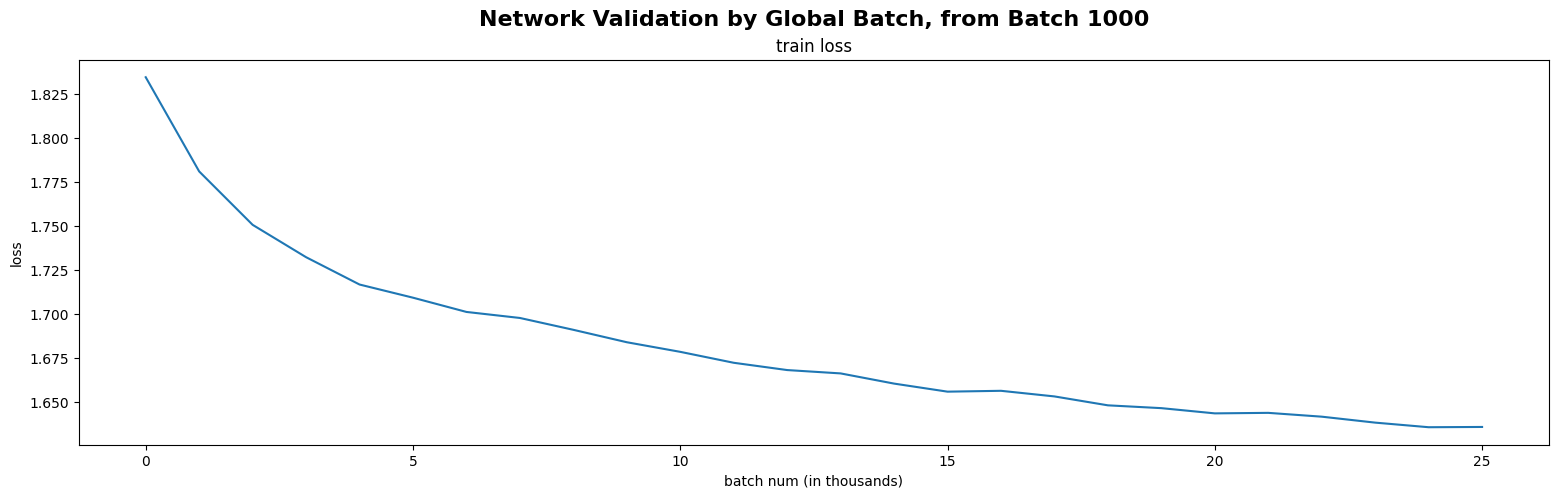

In [ ]:
# create plot for validation set -- from the second batch (in thousands for validation), to show how the model learns over batches
plt.figure(figsize=(15, 5))
X_valids = range(int(len(validation_losses[1:-1])))

plt.plot(np.array(X_valids), np.array(validation_losses[1:-1]))
plt.xlabel("batch num (in thousands)")
plt.ylabel("loss")
plt.title("train loss")

plt.suptitle(f"Network Validation by Global Batch, from Batch 1000", fontsize=16, fontweight='bold')
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.3)
plt.show()